In [1]:
import matplotlib.pyplot as plt
import seaborn as sns 
import pandas as pd
import numpy as np
import os

In [2]:
# global config

# data path
raw_data_dir = 'put'
data_path_gpu = 'benchmark_a21_put_active_cuda_640_100_600.txt'
data_path_cpu = 'benchmark_a21_put_active_cpu_640_100_600.txt'

# set figure size and saving config
rc = {
    'figure.figsize':(12,8.27), 
    'xtick.labelsize': 16, 
    'ytick.labelsize': 16, 
    'axes.titlesize': 20, 
    'axes.labelsize': 18
}
sns.set(rc=rc)

# plot title prefix 
plot_prefix = data_path_gpu.strip().split('_')[0:-4]
plot_prefix = '-'.join(plot_prefix)
print('[plot title prefix]', plot_prefix)

# figure save directory
save_dir = os.path.join('output', raw_data_dir)
if not os.path.exists(save_dir):
    print('creating', save_dir)
    os.mkdir(save_dir)
    
save_subdir = '_'.join(data_path_gpu.strip().split('_')[0:-4])
save_dir = os.path.join(save_dir, save_subdir)
save_dict = dict()
if not os.path.exists(save_dir):
    print('creating', save_dir)
    os.mkdir(save_dir)
        
print('[save to]', save_dir)

[plot title prefix] benchmark-a21-put-active
[save to] output/put/benchmark_a21_put_active


In [3]:
def raw_data_to_dataframe(gpu_data_path, cpu_data_path):
    """
    transfer raw data from test to pandas dataframe 
    example data frame: 
    [put_time]  [sender_num]  [platform]
    0.001           10            GPU-MPI
    0.0001          10            OPEN-MPI 
    ...  
    """
    pd_data = pd.DataFrame(columns = ['put_time', 'sender_num', 'platform'])
    # demo 
    # pd_data = pd_data.append({'sending_time': 0.001, 'thread_num': 10, 'platform': 'GPU-MPI'}, ignore_index=True)
    # pd_data = pd_data.append({'sending_time': 0.0001, 'thread_num': 10, 'platform': 'OPEN-MPI'}, ignore_index=True)

    # read gpu test file
    file = open(gpu_data_path, 'r')
    for line in file.readlines():
        elements = line.strip().split()
        # if the line not starts with '#', then ignored
        if len(elements) == 0 or not elements[0] == '#':
            continue

        row = {
            'put_time': float(elements[4]), 
            'total_time': float(elements[5]), 
            'sender_num': int(elements[1]), 
            'platform': 'GPU-MPI'
        }
        pd_data = pd_data.append(row, ignore_index=True)
    file.close()

    # read cpu test file 
    file = open(cpu_data_path, 'r')
    lines = file.readlines()
    for line in lines:
        elements = line.strip().split()
        # if the line not starts with '#', then ignored
        if len(elements) == 0 or not elements[0] == '#':
            continue

        row = {
            'put_time': float(elements[4]), 
            'total_time': float(elements[5]), 
            'sender_num': int(elements[1]), 
            'platform': 'OPEN-MPI'
        }
        pd_data = pd_data.append(row, ignore_index=True)
    file.close()

    return pd_data

In [4]:
# read data 
thread_time_data = raw_data_to_dataframe(os.path.join(raw_data_dir, data_path_gpu), os.path.join(raw_data_dir, data_path_cpu))
data_num = int(data_path_gpu.strip().split('_')[-3])

In [5]:
def compute_average_total_time(data, data_num, data_size):
    pd_data = pd.DataFrame(columns = ['sender_num', 'platform', 'ave_total_time', 'data_num', 'data_size'])
    i = 0
    while i < len(data):
        # determine the thread number
        sender_num = data.loc[i, 'sender_num']
        
        # compute average total_time
        ave_total_time = np.mean(data.loc[i:i+sender_num-1, 'total_time'])
        
        # add row to new dataframe
        row = {
            'sender_num': sender_num, 
            'platform': data.loc[i, 'platform'], 
            'ave_total_time': ave_total_time, 
            'data_num': data_num, 
            'data_size': data_size, 
            'throughput[GB/s]': sender_num * data_num * data_size / ave_total_time / 1024 / 1024
        }
        pd_data = pd_data.append(row, ignore_index=True)
        
        i += sender_num
    
    return pd_data

In [6]:
block_data = compute_average_total_time(thread_time_data, data_num=data_num, data_size=8)  # double type = 8 bytes
block_data.to_csv(os.path.join(save_dir, 'block_data.csv'))
block_data

,sender_num,platform,ave_total_time,data_num,data_size,throughput[GB/s]
0,1,GPU-MPI,0.092978,640,8,0.052516
1,1,GPU-MPI,0.092963,640,8,0.052524
2,1,GPU-MPI,0.093202,640,8,0.052390
3,1,GPU-MPI,0.093216,640,8,0.052382
4,1,GPU-MPI,0.093141,640,8,0.052424
...,...,...,...,...,...,...
2543,60,OPEN-MPI,0.268776,640,8,1.090009
2544,60,OPEN-MPI,0.287898,640,8,1.017612
2545,60,OPEN-MPI,0.294684,640,8,0.994178
2546,60,OPEN-MPI,0.294420,640,8,0.995070


In [7]:
def data_validity_check(data):
    """
    check data validity from the log. 
    e.g. data point number.
    """
    # filter out platform data 
    cuda_mpi_data = data[data['platform'] == 'GPU-MPI']
    cpu_mpi_data = data[data['platform'] == 'OPEN-MPI']
    
    # create empty container
    result = data.drop(index=range(0, len(data)))
    
    # rule 1: data point number for each thread_num should be the same. 
    thread_num = data['sender_num'].unique()
    print('rule 1 check, sender_num = {}'.format(thread_num))
    expected = len(cuda_mpi_data[cuda_mpi_data['sender_num'] == thread_num[0]])  # init with fisrt #(first cuda data point)
    for n in thread_num:
        _cpu = cpu_mpi_data[cpu_mpi_data['sender_num'] == n]
        _cuda = cuda_mpi_data[cuda_mpi_data['sender_num'] == n]
        len_cpu = len(cpu_mpi_data[cpu_mpi_data['sender_num'] == n])
        len_cuda = len(cuda_mpi_data[cuda_mpi_data['sender_num'] == n])
        if len_cpu > expected:
            print('[warning] [cpu] sender_num = {}, sample {} out of {}'.format(n, expected, len_cpu))
            _cpu = _cpu.sample(n=expected)
        if len_cuda > expected:
            print('[warning] [cuda] sender_num = {}, sample {} out of {}'.format(n, expected, len_cuda))
            _cuda = _cuda.sample(n=expected)
        if len_cpu < expected:
            raise Exception('not enough data for [cpu] sender_num = {}, expect {} but get {}'.format(n, expected, len_cpu))
        if len_cuda < expected:
            raise Exception('not enough data for [cuda] sender_num = {}, expect {} but get {}'.format(n, expected, len_cuda))
        
        result = pd.concat([result, _cpu, _cuda])
    
    return result

In [8]:
thread_time_data[thread_time_data['platform'] == 'GPU-MPI']
thread_time_data[thread_time_data['platform'] == 'OPEN-MPI']

,put_time,sender_num,platform,total_time
8465,0.000014,1,OPEN-MPI,0.001370
8466,0.000004,1,OPEN-MPI,0.000381
8467,0.000004,1,OPEN-MPI,0.000373
8468,0.000004,1,OPEN-MPI,0.000371
8469,0.000004,1,OPEN-MPI,0.000372
...,...,...,...,...
16925,0.001159,60,OPEN-MPI,0.271997
16926,0.001160,60,OPEN-MPI,0.295985
16927,0.001400,60,OPEN-MPI,0.251998
16928,0.001240,60,OPEN-MPI,0.311989


In [9]:
# x = data_validity_check(thread_time_data)
back_up = thread_time_data.copy()  # leave a backup 
# thread_time_data = x
back_up

,put_time,sender_num,platform,total_time
0,0.000929,1,GPU-MPI,0.092978
1,0.000929,1,GPU-MPI,0.092963
2,0.000932,1,GPU-MPI,0.093202
3,0.000932,1,GPU-MPI,0.093216
4,0.000931,1,GPU-MPI,0.093141
...,...,...,...,...
16925,0.001159,60,OPEN-MPI,0.271997
16926,0.001160,60,OPEN-MPI,0.295985
16927,0.001400,60,OPEN-MPI,0.251998
16928,0.001240,60,OPEN-MPI,0.311989


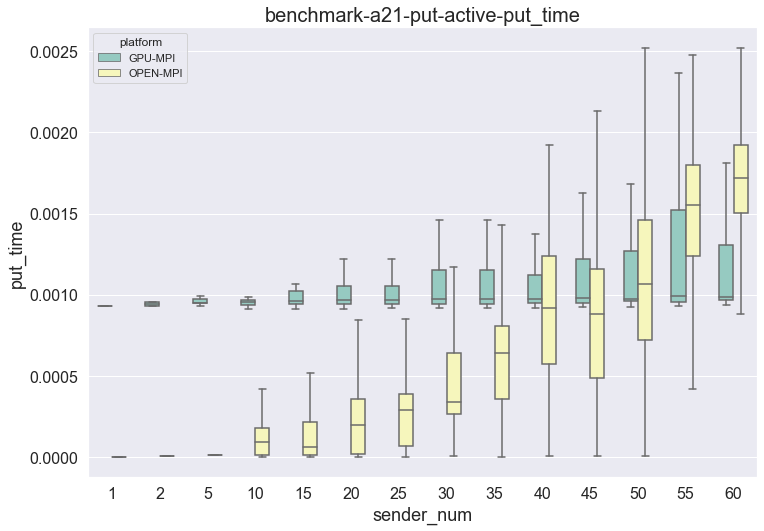

In [10]:
# general box plot
ax = sns.boxplot(x="sender_num", y="put_time", hue='platform', data=thread_time_data, palette="Set3", showfliers=False, width=0.6)
ax.set_title(f'{plot_prefix}-put_time')
save_dict[f'{plot_prefix}-put_time-boxplot'] = ax

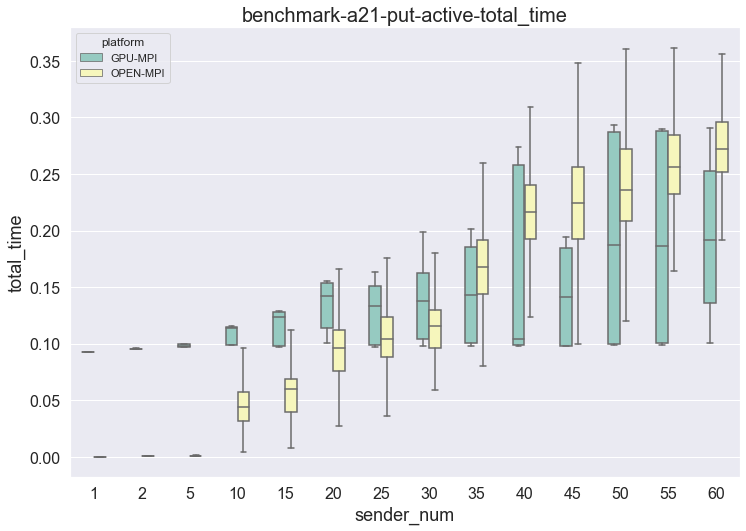

In [11]:
# general box plot for total time
ax = sns.boxplot(x="sender_num", y="total_time", hue='platform', data=thread_time_data, palette="Set3", showfliers=False, width=0.5)
ax.set_title(f'{plot_prefix}-total_time')
save_dict[f'{plot_prefix}-total_time-boxplot'] = ax

In [12]:
# line plot for put time
def line_plot_median_quartile(time_key):
    ax = sns.lineplot(x="sender_num", y=time_key, hue='platform', data=thread_time_data, palette="Set2", estimator=np.median, ci=None)
    # generate quatile bound manually
    for p in thread_time_data['platform'].unique():
        data = thread_time_data[thread_time_data['platform'] == p]
        bounds = data.groupby('sender_num')[time_key].quantile((0.25,0.75)).unstack()
        ax.fill_between(x=bounds.index,y1=bounds.iloc[:,0],y2=bounds.iloc[:,1],alpha=0.1)
    return ax

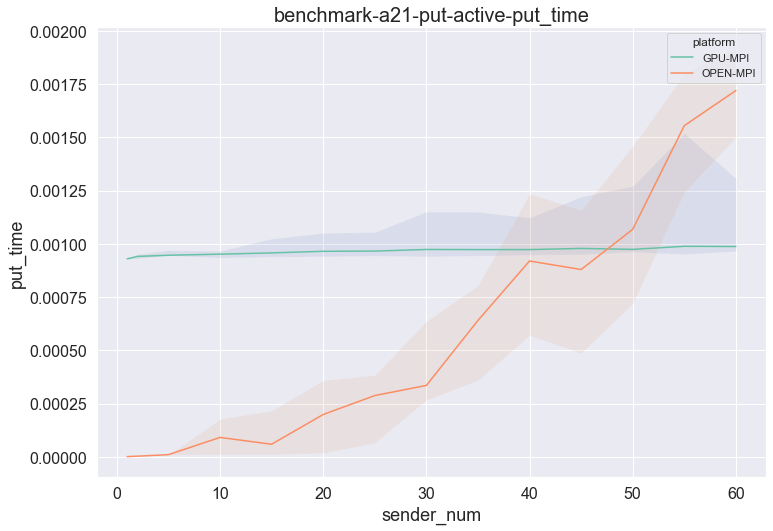

In [13]:
# line plot: put time, median-quartile
ax = line_plot_median_quartile(time_key='put_time')
ax.set_title(f'{plot_prefix}-put_time')
save_dict[f'{plot_prefix}-put_time-lineplot'] = ax

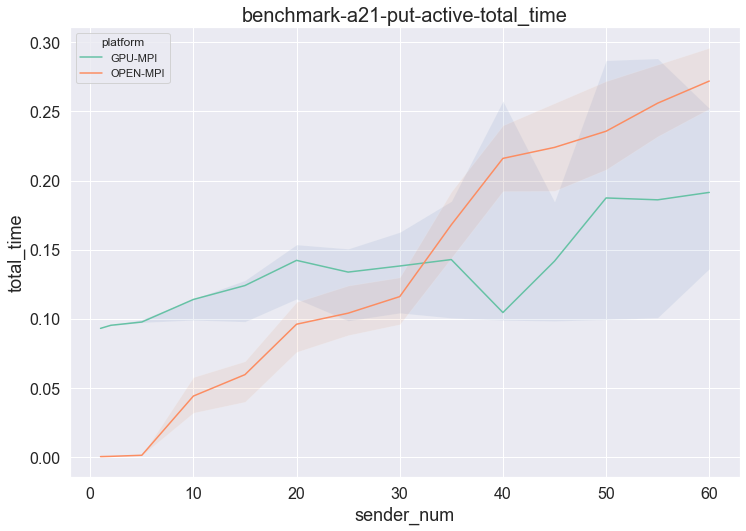

In [14]:
# line plot: total time, median-quartile
ax = line_plot_median_quartile(time_key='total_time')
ax.set_title(f'{plot_prefix}-total_time')
save_dict[f'{plot_prefix}-total_time-lineplot'] = ax

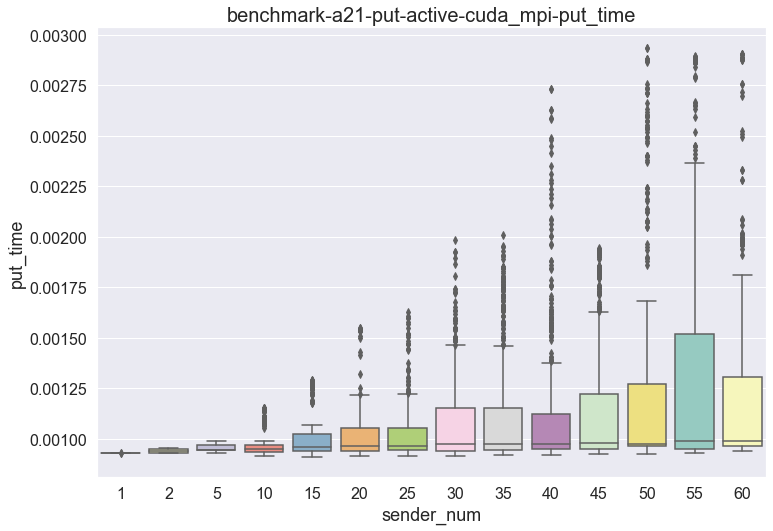

In [15]:
# subplot for gpu put time only 
data_gpu = thread_time_data[thread_time_data['platform'] == 'GPU-MPI']
ax = sns.boxplot(x="sender_num", y="put_time", data=data_gpu, palette="Set3", showfliers=True) 
ax.set_title(f'{plot_prefix}-cuda_mpi-put_time')
save_dict[f'{plot_prefix}-cuda_mpi-put_time-boxplot'] = ax

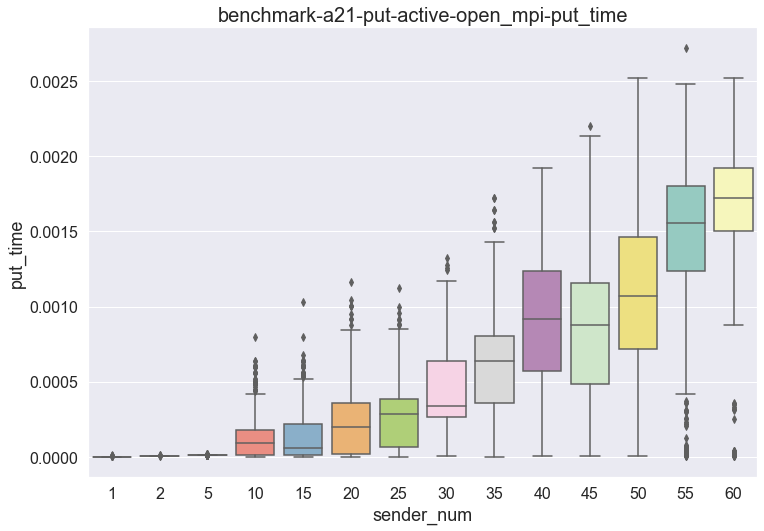

In [16]:
# subplot for cpu put time only 
data_cpu = thread_time_data[thread_time_data['platform'] == 'OPEN-MPI']
ax = sns.boxplot(x="sender_num", y="put_time", data=data_cpu, palette="Set3")
ax.set_title(f'{plot_prefix}-open_mpi-put_time')
save_dict[f'{plot_prefix}-open_mpi-put_time-boxplot'] = ax

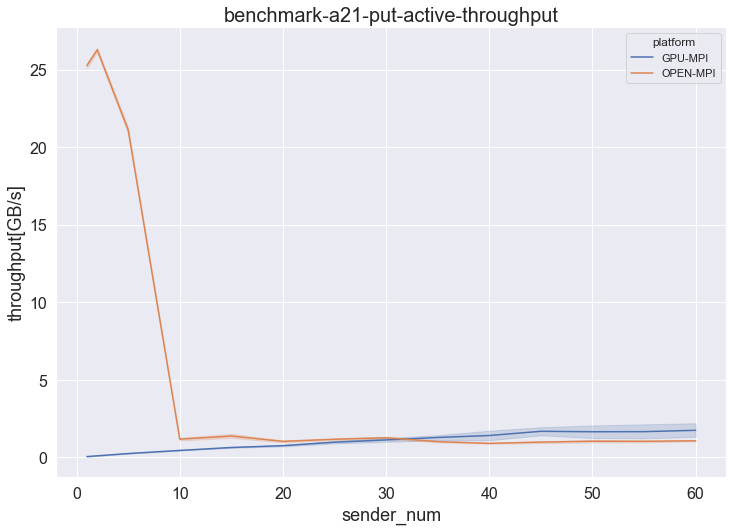

In [17]:
# throughput plot 
data_throughput = sns.lineplot(x='sender_num', y='throughput[GB/s]', hue='platform', data=block_data)
data_throughput.set_title(f'{plot_prefix}-throughput')
save_dict[f'{plot_prefix}-throughput-lineplot'] = data_throughput

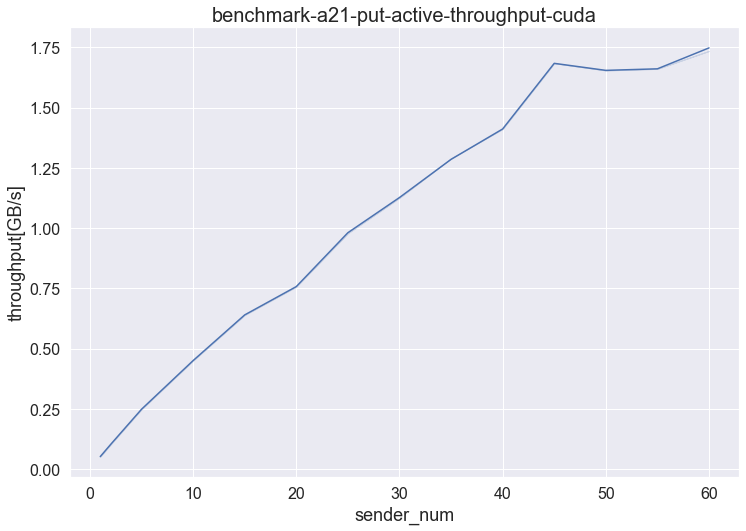

In [18]:
# throughput plot - gpu 
data_throughput = sns.lineplot(x='sender_num', y='throughput[GB/s]', data=block_data[block_data['platform'] == 'GPU-MPI'], ci=0)
data_throughput.set_title(f'{plot_prefix}-throughput-cuda')
save_dict[f'{plot_prefix}-throughput-cuda-lineplot'] = data_throughput

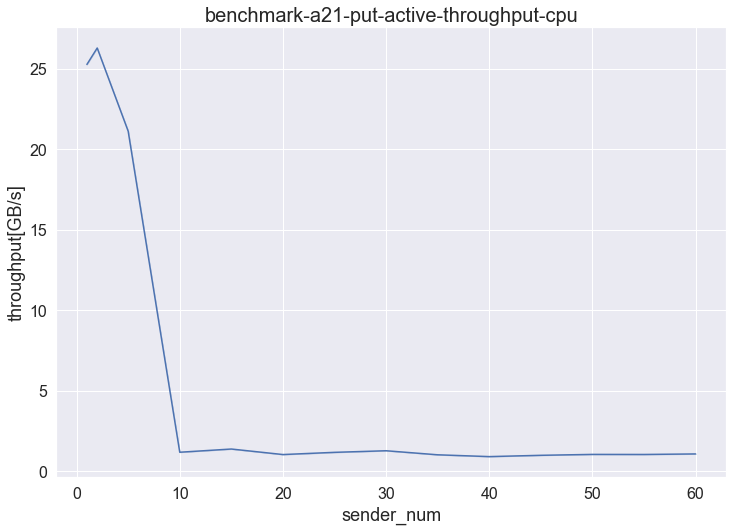

In [19]:
# throughput plot - cpu 
data_throughput = sns.lineplot(x='sender_num', y='throughput[GB/s]', data=block_data[block_data['platform'] == 'OPEN-MPI'], ci=0)
data_throughput.set_title(f'{plot_prefix}-throughput-cpu')
save_dict[f'{plot_prefix}-throughput-cpu-lineplot'] = data_throughput

In [20]:
# dump images
for k in save_dict:
    print(f'saving {k} ....')
    fig = save_dict[k].get_figure()
    fig.savefig(os.path.join(save_dir, f'{k}.pdf'))
    fig.savefig(os.path.join(save_dir, f'{k}.png'))
print('save figure done')

saving benchmark-a21-put-active-put_time-boxplot ....
saving benchmark-a21-put-active-total_time-boxplot ....
saving benchmark-a21-put-active-put_time-lineplot ....
saving benchmark-a21-put-active-total_time-lineplot ....
saving benchmark-a21-put-active-cuda_mpi-put_time-boxplot ....
saving benchmark-a21-put-active-open_mpi-put_time-boxplot ....
saving benchmark-a21-put-active-throughput-lineplot ....
saving benchmark-a21-put-active-throughput-cuda-lineplot ....
saving benchmark-a21-put-active-throughput-cpu-lineplot ....
save figure done
